Reference video: 
https://www.youtube.com/watch?v=_SWnNhM5w-g&list=PL58zEckBH8fBW_XLPtIPlQ-mkSNNx0tLS&index=6

In [1]:
# Import necessary libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

### Training with Q Table

In [9]:
def mountain_car(name, episodes, is_training=True, render=False):
    env = gym.make(
        'MountainCar-v0', 
        render_mode='human' if render else None
    )
    
    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20) # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20) # Between -0.7 and 0.7
    
    # Define Q Table
    if is_training:
        q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))  # 20x20x3 Q table
    else:
        f = open(f'q_tables/q_{name}.pkl', 'rb')
        q = pkl.load(f)
        f.close()
    
    # Define the hyperparameters
    learning_rate_a = 0.9   # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount factor
    
    # Define policy parameters: we use the Epsilon Greedy Algorithm
    epsilon = 1                         # 1 = 100% random actions
    epsilon_decay_rate = 2 / episodes   # decay rate of epsilon
    rng = np.random.default_rng()       # random number generator
    
    # Keep track of the rewards per episode
    rewards_per_episode = np.zeros(episodes)
    
    # Iterate through all episodes
    for i in range(episodes):
        state = env.reset()[0]  
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        terminated = False      # True when the agent falls into a hole or reaches the goal    
        rewards = 0
        
        while(not terminated and rewards > -1000):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()  # Actions: 0-left, 1-down, 2-right, 3-up
            else:
                action = np.argmax(q[state_p, state_v, :])
            
            new_state, reward, terminated, _, _ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            
            # Apply the Q Learning formula after taking a step
            if is_training:
                q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state_p, new_state_v,  :]) - q[state_p, state_v, action]
                )
            
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            rewards += reward
        
        # Decrease epsilon after each episode until it reaches 0
        epsilon = max(epsilon - epsilon_decay_rate, 0)  
        
        # Decrease the learning rate if epsilon reaches 0
        if epsilon == 0:
            learning_rate_a = 0.0001
            
        # Save episode reward
        rewards_per_episode[i] = rewards
    
    # Close the environment
    env.close()
    
    # Plot the rewards per episode graph
    if render == False:
        mean_rewards = np.zeros(episodes)
        for t in range(episodes):
            mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.plot(mean_rewards)
    
    # Save the Q Table
    if is_training:
        f = open(f'q_tables/q_{name}.pkl', 'wb')
        pkl.dump(q, f)
        f.close()  
        print('Training completed!')

Training completed!


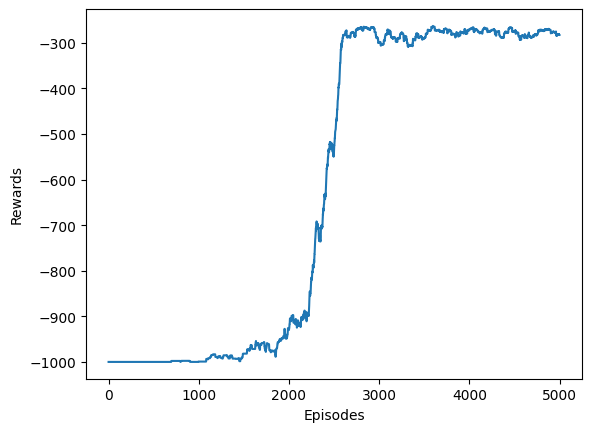

In [10]:
# Train with 15000 episodes
name = 'mountain_car'
mountain_car(name, 5000)

In [13]:
# Watch the trained agent
mountain_car(name, 3, is_training=False, render=True)